In [1]:

import warnings
warnings.filterwarnings('ignore') 

import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import contractions
import re
from nltk.tokenize import TweetTokenizer


In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np
import string
import nltk
from nltk.util import bigrams, trigrams
from nltk.corpus import stopwords
from gensim.models import Word2Vec #install gensim # had to use this: pip install --upgrade gensim smart_open protobuf==3.20.0
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from scipy.stats import chi2_contingency

In [3]:
data = pd.read_csv("stock_data.csv")

data cleaning

In [4]:
#removing contractions
data['Text_unigram'] = data['Text'].apply(contractions.fix)
#change to lower case
data['Text_unigram'] = data['Text_unigram'].apply(lambda text:text.lower())

Tokenisation, stopword removal, lemmatization

In [5]:
# Unigram Tokenizing
tweettokenizer = TweetTokenizer()
data["Text_unigram"] = data['Text_unigram'].apply(tweettokenizer.tokenize)

stop_words = set(stopwords.words('english'))

to_remove = ["no","not", "on", "off", "too", "out", "over", "under"] #want to keep some words that connote sentiment/ words that are finance related?
for word in to_remove:
    stop_words.remove(word)
def filter_unigrams(tokens):
    return [token for token in tokens if token not in stop_words]
data["Text_unigram"] = data["Text_unigram"].apply(filter_unigrams)


lemmatizer = WordNetLemmatizer()
def lemmatize_unigrams(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]
data["Text_unigram"] = data["Text_unigram"].apply(lemmatize_unigrams)

TF-IDF

In [20]:
tfvectorizer = TfidfVectorizer(min_df = 20, ngram_range=(1, 3)) #min appearance 10 times to reduce dimensionality
documents = data['Text_unigram'].apply(lambda tokens_list:' '.join(tokens_list))
tfidf_matrix= tfvectorizer.fit_transform(documents)
tfidf_matrix_csr = csr_matrix(tfidf_matrix)
data['Text_tfidf'] = [row for row in tfidf_matrix_csr]
feature_names = tfvectorizer.get_feature_names_out()

General Text Features

In [21]:
# Word Count
data['word_count'] = data['Text'].apply(lambda x: len(str(x).split())) #note that its post 
data['unigram_count'] = data['Text_unigram'].apply(lambda x: len(x))

# Unique Word Count
data['unique_word_count'] = data['Text'].apply(lambda x: len(set(str(x).split())))
data['unique_unigram_count'] = data['Text_unigram'].apply(lambda x: len(set(x)))

# Stop Word Count
stop = stopwords.words('english')
data['stopword_count'] = data['Text'].apply(lambda x: len([word for word in str(x).split() if word.lower() in stop]))

# Mean Word Length
data['mean_word_length'] = data['Text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
data['mean_unigram_length'] = data['Text_unigram'].apply(lambda x: np.mean([len(token) for token in x]))

# Character Count
data['char_count'] = data['Text'].apply(lambda x: len(str(x)))

# Punctuation Count
data['punctuation_count'] = data['Text'].apply(lambda x: len([char for char in str(x) if char in string.punctuation]))

# Number Count
data['number_count'] = data['Text'].apply(lambda x: len([word for word in str(x).split() if word.isdigit()]))
gen_features = ['word_count', 'unigram_count', 'unique_word_count', 'unique_unigram_count', 'stopword_count', 'mean_word_length', 'mean_unigram_length', 'char_count', 'punctuation_count', 'number_count']

EDA

Total Number of Entries before reduction: 5791
Distribution of Labels
Sentiment
 1    3685
-1    2106
Name: count, dtype: int64
Number of dimensions for tdidf: 581


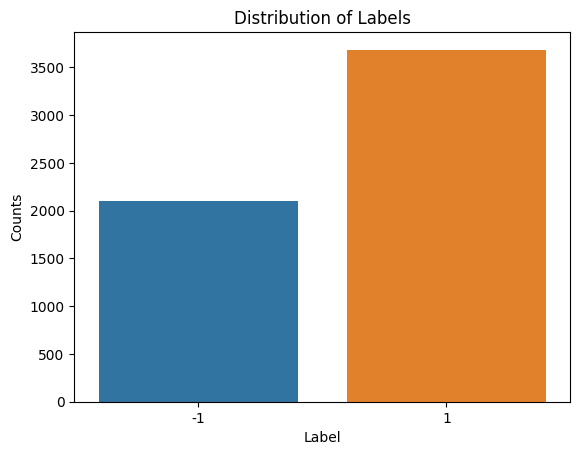

In [22]:
#print(data[data["Text"].isna()]) #check for NAs
#print(data[data["Sentiment"].isna()]) #check for NAs
sns.countplot(data, x = "Sentiment")
plt.title("Distribution of Labels")
plt.xlabel("Label")
plt.ylabel("Counts")

print("Total Number of Entries before reduction:",len(data))
print("Distribution of Labels")
print(data["Sentiment"].value_counts())

print("Number of dimensions for tdidf:",data['Text_tfidf'][0].shape[1])


In [23]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from scipy.sparse import hstack
additional_features = csr_matrix(data[gen_features].values)
X_features = hstack([tfidf_matrix, additional_features])

# Combine the feature names with the names of the additional features
all_feature_names = np.concatenate((feature_names, gen_features))

X_train, X_test, y_train, y_test = train_test_split(X_features, data['Sentiment'], test_size=0.2, stratify=data['Sentiment'], random_state=42)

# Convert to dense format and create DataFrame
X_train_df = pd.DataFrame(X_train.toarray(), columns=all_feature_names)
X_test_df = pd.DataFrame(X_test.toarray(), columns=all_feature_names)

# To apply oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_df, y_train)

train = pd.concat([X_resampled, y_resampled.reset_index(drop=True)], axis=1)
test = pd.concat([X_test_df, y_test.reset_index(drop=True)], axis=1)

print('Resampled train data shape:', Counter(y_resampled))
print('Test data shape:', Counter(y_test))


Resampled train data shape: Counter({1: 2947, -1: 2947})
Test data shape: Counter({1: 738, -1: 421})


In [24]:
train.to_csv("train.csv")
test.to_csv("test.csv")